In [1]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

from importlib import reload
from copy import deepcopy
from typing import List, Dict
from collections import deque, namedtuple

import random
import math

import utils.plots_cliffwalking as plots
from env.cliff_walking import WindyCliffWalking

from IPython import display

plt.ion()

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Solving the Cliff Walking Environment with Deep Q-Learning

The [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) environment will be used again to understand how Deep Q-Learning, the simplest Deep Reinforcement Learning algorithm, works. Recapping the objective of Cliff Walking: the agent must traverse a grid from start to finish while avoiding falling off a cliff. If the agent falls off the cliff, it returns to the start of the grid and receives a penalty.

<img src="media/cliff_walking.gif" width="200">

Below are some important details for modeling the environment as a Markov Decision Process (MDP):

### Action Space

The action space is discrete and contains integers in the range {0, 3}. An action specifies the direction of a movement:
* 0: Up
* 1: Right
* 2: Down
* 3: Left

### State Space

The state represents the agent's position on the grid. Thus, the state space is also discrete and contains integers in the range {0, 47}. The numeric value of the agent's position on the grid can be obtained as `current_row * n_rows + column`, with rows and columns starting at 0.

### Rewards

For each movement the agent makes, a penalty of -1 is applied, unless the agent falls off the cliff, which results in a penalty of -100.

## Creating the Model

In Deep Q-Learning, the Q-values of each action associated with a state are calculated using a neural network. In other words, the neural network takes a state vector as input and returns a Q-value vector, where each element represents the Q-value of an action. A Q-value can be interpreted as "the expected total accumulated reward for taking action A in state S and then following the same policy until the end of the episode."

Since this is a relatively simple problem, the model used to solve Cliff Walking can be an MLP (Multi-Layer Perceptron) network. Additionally, note that predicting Q-values is a regression task, so a softmax activation function is not used at the end of the network.

### Integer to (x, y) Conversion

The neural network becomes simpler if it receives a pair (x, y) as input instead of an integer. If we were to feed it an integer, we would need to convert that integer to a one-hot encoding. Since there are 48 states, this would require a 48-element vector with 47 zeroed elements! By passing a pair (x, y), the vector is reduced to just two elements. The method `_encode_state()` encodes the state as the agent's position and transforms it into a tensor.

In [2]:
class Qnet(nn.Module):
    def __init__(self, layer_sizes: List[int] = [64, 64]):
        super().__init__()

        # construindo a rede neural
        layers = []
        input_size = 2 # entrada: posicao (x, y)
        for n_neurons in layer_sizes:
            layers.append(nn.Linear(input_size, n_neurons))
            layers.append(nn.ReLU())
            input_size = n_neurons
        layers.append(nn.Linear(input_size, 4))
        self.nn = nn.Sequential(*layers).to(DEVICE)

    def _encode_state(self, state: int | torch.Tensor) -> torch.Tensor:
        if isinstance(state, int):
            state = torch.tensor(state, dtype=torch.float32)

        x = (state % 12) / 11
        y = (state // 12) / 3

        x = x.reshape(-1, 1)
        y = y.reshape(-1, 1)

        return torch.cat([x, y], dim=-1).to(DEVICE)

    def forward(self, x):
        x = self._encode_state(x)
        x = self.nn(x)
        return x

## Replay Buffer

Replay buffers are used to store state transitions observed during the training process. The neural network uses batches of transitions (not necessarily sequential!) to calculate the loss and update its weights. Using replay buffers makes the learning process more efficient by allowing the network to learn from a transition multiple times and by helping to improve the stability of neural network training.

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'terminated'))

class ReplayBuffer:
    def __init__(self, capacity=1024):
        self.buffer = deque([], maxlen=capacity)
    
    def push(self, *args):
        """ Save a transition into the buffer."""
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)


## Sampling Actions with the $\epsilon$-Greedy Policy

At the end of training, the best action for each state is expected to be the one with the highest Q-value. However, for Q-Learning to converge properly, the agent must "explore" the environment thoroughly at the beginning of training. This means the agent should visit a large number of states, even if they are not necessarily optimal. A widely used technique for this purpose is the $\epsilon$-greedy policy. It forces the agent to choose actions randomly with a frequency that decreases as training progresses.

In [4]:
@torch.no_grad()
def get_action(model, state, epsilon, random=True, n_actions=4):
    if torch.rand(1) < epsilon and random:
        return torch.randint(n_actions, (1,)).item()
    qvals = model(state)
    return torch.argmax(qvals).item()

## Neural Network Training 

At each training step, the agent will perform an action and use the information returned by the environment to calculate a loss and update its weights to minimize it. The loss used will be the mean squared error between the selected Q-value and the highest Q-value of the next state, calculated using the network with weights from the previous update:

$$L_i(\theta_i)=\mathbb{E}[(y_i - Q(s,a;\theta_i))^2]$$  
$$y_i=\mathbb{E}[R(s')+\gamma\max_A Q(s',A;\theta_{i-1})]$$  

Note that, therefore, two neural networks with the same architecture will be required, but one will have weights delayed by one iteration compared to the other.

In [5]:
def update_q_net(model: Qnet, 
                 model_target: Qnet,
                 optimizer: torch.optim.Optimizer, 
                 batch_of_transitions: List[Transition],
                 gamma):
    
    # Convert a list of Transitions into a Transition of lists
    # Check: https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip/19343#19343
    batch = Transition(*zip(*batch_of_transitions))
    
    # transforming the state batch into a tensor
    states = torch.tensor(batch.state, dtype=torch.float32)
    actions = torch.tensor(batch.action, dtype=torch.int64).to(DEVICE)
    rewards = torch.tensor(batch.reward, dtype=torch.float32).to(DEVICE)
    next_states = torch.tensor(batch.next_state, dtype=torch.float32)
    terminated = torch.tensor(batch.terminated, dtype=torch.float32).to(DEVICE)
    
    predictions = model(states).gather(1, actions.unsqueeze(1)).squeeze() # select the Q(s, a) for the actions taken

    # if in the final state, the expected value is the reward itself
    with torch.no_grad():
        targets = rewards + gamma * model_target(next_states).max(-1).values * (1 - terminated.int()) # else rewards + gamma * max_a Q(s', a)
    
    loss = F.mse_loss(predictions, targets)

    # update the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return model

## Training Loop

In the training loop, we will combine all the functions developed so far. The main idea is to define a maximum number of episodes (from the initial stage to the final stage) so that the agent can gather experiences from the environment and optimize its Q-value table.

In [6]:
class Heatmap:
    def __init__(self, rows, cols):
        self.heatmap = torch.zeros(rows, cols)
    
    def update(self, state):
        col = state % 12
        row = state // 12
        self.heatmap[row][col] += 1

    def clear(self):
        self.heatmap = torch.zeros(self.heatmap.shape)
    
    def plot(self, episode):
        print(self.heatmap.int())
        plt.imshow(self.heatmap, cmap='hot', interpolation='nearest')
        plt.title(f'Heatmap for the last 20 eps from ep {episode}')
        plt.show()

In [7]:
def evaluate(metrics: Dict, show_results=False):
    rewards = torch.tensor(metrics['episode_rewards'])
    plt.figure(1)
    plt.clf
    plt.title('Total reward of each episode')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.plot(rewards)

    # Take 100 episode averages and plot them too
    if metrics['avg_reward'] is not None: 
        x = range(49, 49 + len(metrics['avg_reward']))
        plt.plot(x, metrics['avg_reward'].numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated

    # plot heatmap
    metrics['heatmap'].plot(len(metrics['episode_rewards']))

    # dump qtable
    for i, q in enumerate(metrics['qtable']):
        if i not in range(37, 47):
            print(f'Q values for state {i}: {q}')

    if not show_results:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())


In [8]:
def train(
        env: gym.Env, 
        model: Qnet,
        total_steps=35_000,
        replay_buffer_size=10_000, # replay buffer size
        batch_size=64, # batch size
        gamma=0.99,
        learning_rate=1e-4,
        learning_freq=1,
        target_update_freq=100,
        tau=1.0,
        epsilon_0 = 1, # initial probability of taking a random action
        epsilon_f=0.05, # final probability of taking a random action (after decay)
        epsilon_decay = 100_000 # step in which epsilon will be approximately epsilon_f + 0.36 * (epsilon_0 - epsilon_f)
        ):
    
    model_target = deepcopy(model)

    def eps_scheduler(step):
        return epsilon_f + (epsilon_0 - epsilon_f) * math.exp(-1. * step / epsilon_decay)

    replay_buffer = ReplayBuffer(replay_buffer_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    state, _ = env.reset()
    total_reward = 0
    metrics = {
        'episode_rewards': [],
        'avg_reward': None,
        'heatmap': Heatmap(4, 12),
    }
    episode_step = 0
    truncated = False

    for global_step in range(total_steps):
        epsilon = eps_scheduler(global_step)

        # observe
        action = get_action(model, state, epsilon)
        next_state, reward, terminated, _, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, terminated)
        state = next_state
        metrics['heatmap'].update(state)
        total_reward += reward
        episode_step += 1
        if episode_step > 1000:
            truncated = True
        done = terminated or truncated

        # update
        if global_step > batch_size and global_step % learning_freq == 0:
            batch = replay_buffer.sample(batch_size)
            model = update_q_net(model, model_target, optimizer, batch, gamma)

        # update target network
        if global_step % target_update_freq == 0:
            model_target.load_state_dict(model.state_dict())

        # evaluating
        if done:
            metrics['episode_rewards'].append(total_reward)
            if len(metrics['episode_rewards']) > 50:
                metrics['avg_reward'] = torch.tensor(metrics['episode_rewards']).float().unfold(0, 50, 1).mean(1)
                print(f'avg reward: {metrics["avg_reward"][-1]}')
            with torch.no_grad():
                metrics['qtable'] = model(torch.arange(48))
            print(f'current step: {global_step}, epsilon: {epsilon:.2f}')
            evaluate(metrics)
            total_reward = 0
            metrics['heatmap'].clear()
            state, _ = env.reset()
            episode_step = 0
            truncated = False

    return model

## Training

Everything is set up, so now we can run the algorithm!

In [9]:
class QnetEmb(nn.Module):
    def __init__(self, n_actions=4):
        super().__init__()
        self.nn = nn.Embedding(48, n_actions).to(DEVICE)

    def _encode_state(self, state: int | torch.Tensor) -> torch.Tensor:
        return torch.tensor(state).long().to(DEVICE)
    
    def forward(self, x):
        x = self._encode_state(x)
        x = self.nn(x)
        return x

In [10]:
cliff_walking = gym.make('CliffWalking-v0')
q_net = Qnet()
debug_model = deepcopy(q_net)
trained_q_net = train(cliff_walking, q_net, epsilon_decay=10_000, learning_rate=1e-3, verbose=True)

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

## Testing the agent

The function below will run an episode with the trained agent.

In [ ]:
def test(env: gym.Env, 
          q_net,
          n_episodes=1,
          verbose=False
          ):
    
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = get_action(q_net, state, 0)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            done = terminated or truncated

        if verbose:
            print(f"Episode {episode} - Total reward: {total_reward}")
            
        total_rewards.append(total_reward)

    env.close()
    return torch.mean(total_reward)

test(gym.make('CliffWalking-v0', render_mode="human"), trained_q_net)

NameError: name 'gym' is not defined

## Results Analysis

### Visualizing the Policy

The cell below will allow observing the most likely action to be taken in each position on the board.

/tmp/ipykernel_24739/1860028285.py:20: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y = (state // 12) / 3


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

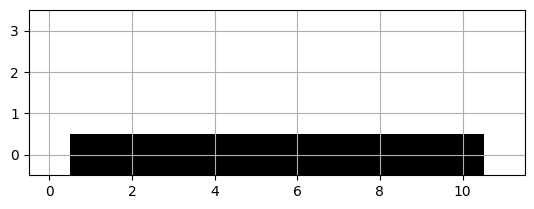

In [ ]:
reload(plots)
plots.plot_arrows_from_qnet(debug_model)